In [27]:
%matplotlib inline
import os
import numpy as np
import requests
import matplotlib.pyplot as plt

More info on how a WCS request type works can be found <a href="https://nbviewer.jupyter.org/github/earthserver-eu/OGC_WCS_tutorial/blob/master/02-WCS_core_requests.ipynb">here</a>.

## WCPS request

There are three main components of a WCS request: <br>
 - <b>Service endpoint</b>: http://earthserver.ecmwf.int/rasdaman/ows?
 - <b>Service and version specification</b>: service=WCS&version=2.0.1
 - <b>Request type</b>: &ProcessCoverages
 - <b>query parameter</b>: &query = for c in (id) return encode (c[Lat(ymin:ymax), Long(xmin:xmax), ansi("1990-01-01T00:00":"1990-01-31T00:00")], "format")

Note: Format can be netcdf, csv or png.

### The concatenated request can look like this:

In [153]:
url_fmt = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
          '&request=ProcessCoverages' \
          '&query=for c in (%s) return encode(c[Lat(%d:%d),Long(%d:%d),ansi("%s":"%s")], "csv")'

NOTE: if you want to retrieve the data as netcdf, then you have to exchange "csv" with "netcdf"

## Example of spatially subsetting the datacube

Example to retrieve a spatial subset (Italy) for one year (1988) of the global datacube.

<b>Dataset</b>: geff_fire_weather_index  
<b>Time bounds</b>: 1 Jan 1988 - 31 Dec 1988  
<b>Bounding Box</b>:  
    - xmin: 6.63
    - xmax: 18.78
    - ymin: 35.29
    - ymax: 47.09

### Build the WCPS request

In [154]:
url = url_fmt % ("geff_fire_weather_index", 35.29, 47.09, 6.63, 18.78, "1988-01-01T00:00","1988-12-31T00:00")
print url

http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for c in (geff_fire_weather_index) return encode(c[Lat(35:47),Long(6:18),ansi("1988-01-01T00:00":"1988-12-31T00:00")], "csv")


Note, you can also follow the link and request the data in the browser.

### Retrieve the data with a http request and store the information in a numpy array

In [155]:
r= requests.get(url,
                proxies={'http':"http://proxy.ecmwf.int:3333"}
                )

r.raise_for_status()
x = np.array(eval(r.text.replace('{','[').replace('}',']')))

In [156]:
# Result is a datacube with lat 18, lon 18 and time 365
x.shape

(366, 18, 18)

## Example spatial statistics

### Retrieve summary statistics of the entire datacube

The result is one value. Average (avg), minimum (min) and maximum (max) can be specified. 

In [157]:
url_fmt = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
'&request=ProcessCoverages' \
'&query=for c in (%s) return encode (%s(c[Lat(%d:%d),Long(%d:%d),ansi("%s":"%s")]),"csv")'

#### Example to retrieve avg, min and max for the italian datacube for the year 1980

In [158]:
url_avg = url_fmt % ("geff_fire_weather_index", "avg", 35.29, 47.09, 6.63, 18.78, "1988-01-01T00:00","1988-12-31T00:00")
url_min = url_fmt % ("geff_fire_weather_index", "min", 35.29, 47.09, 6.63, 18.78, "1988-01-01T00:00","1988-12-31T00:00")
url_max = url_fmt % ("geff_fire_weather_index", "max", 35.29, 47.09, 6.63, 18.78, "1988-01-01T00:00","1988-12-31T00:00")

In [161]:
r= requests.get(url_min,
                proxies={'http':"http://proxy.ecmwf.int:3333"}
                )

r.raise_for_status()
print r.text

0


Minimum, maximum and average fire index values for the entire datacube are 0, 127.315 and 9.58 respectively.

### Retrieve FWI fields for one year (1988) and process the annual average of every grid-point on-the-fly

WCPS request of retrieving all fields (Italian bounding box) of one specific year and processing the annual average of every grid-point on-the-fly. The query condenses a 3D datacube into its 2D average.


In [166]:
url_fmt = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
    '&request=ProcessCoverages&' \
    'query=for c in (%s) return encode((condense + over $x x(imageCrsDomain(c[ansi("%s":"%s")], ansi)) using c[Lat(%d:%d), Long(%d:%d), ansi($x)]/%d), "csv")'

In [170]:
url_avg = url_fmt % ("geff_fire_weather_index", "1988-01-01T00:00","1988-12-31T00:00", 35.29, 47.09, 6.63, 18.78, 366)
print url_avg

http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for c in (geff_fire_weather_index) return encode((condense + over $x x(imageCrsDomain(c[ansi("1988-01-01T00:00":"1988-12-31T00:00")], ansi)) using c[Lat(35:47), Long(6:18), ansi($x)]/366), "csv")


Note: at the end, you have to specify the number of slices of the datacube. For one year e.g. 365/366, if data is daily.

In [171]:
t= requests.get(url_avg,
                proxies={'http':"http://proxy.ecmwf.int:3333"}
                )

t.raise_for_status()
y = np.array(eval(t.text.replace('{','[').replace('}',']')))

In [172]:
y.shape

(18, 18)

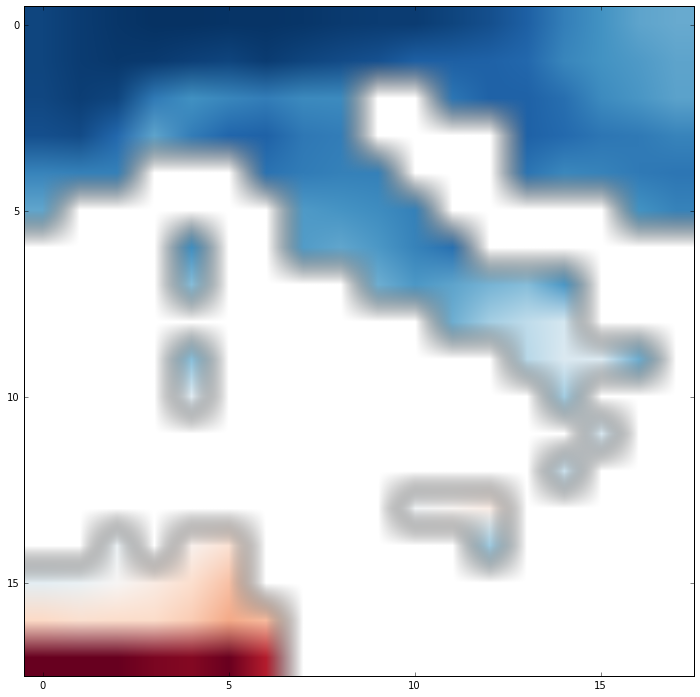

In [173]:
y[y==-9999]=np.nan
fig = plt.figure(figsize=(12,12))
my_cmap = plt.get_cmap('RdBu_r')
plt.imshow(np.flipud(y[:,:]), cmap=my_cmap, vmin=0, vmax=37)
plt.show()

### Have fun! In case of questions, just let me know!